In [72]:
from bs4 import BeautifulSoup
import requests

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
from scipy.stats import levene
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.multicomp import pairwise_tukeyhsd

import string
import time

In [3]:
alphabet = string.ascii_lowercase

fighter_details = {}

for letter in alphabet:

    response = requests.get(f"http://www.ufcstats.com/statistics/fighters?char={letter}&page=all")
    
    soup = BeautifulSoup(response.text, "lxml")
    
    fighter_details[letter] = soup.find_all("td",{'class':'b-statistics__table-col'})
    

In [4]:
# fighter_details

In [5]:
fighter_first_names = []

for key, value in fighter_details.items():
    for fighter in np.arange(0, len(fighter_details[key]), 11):
        fighter_first_name = value[fighter].text.split("\n")[1]
        fighter_first_names.append(fighter_first_name)

In [6]:
len(fighter_first_names)

3412

In [7]:
# fighter_first_names

In [8]:
fighter_last_names = []

for key, value in fighter_details.items():
    for fighter in np.arange(1, len(fighter_details[key]) + 1, 11):
        fighter_last_name = value[fighter].text.split("\n")[1]
        fighter_last_names.append(fighter_last_name)

In [9]:
len(fighter_last_names)

3412

In [10]:
# fighter_last_names

In [11]:
fighter_nick_names = []

for key, value in fighter_details.items():
    for fighter in np.arange(2, len(fighter_details[key]) + 2, 11):
        fighter_nick_name = value[fighter].text.split("\n")[1]
        fighter_nick_names.append(fighter_nick_name)

In [12]:
len(fighter_nick_names)

3412

In [13]:
# fighter_nick_names

In [14]:
fighter_heights = []

for key, value in fighter_details.items():
    for fighter in np.arange(3, len(fighter_details[key]) + 3, 11):
        fighter_height = value[fighter].text.split("\n")[1][10:]
        fighter_heights.append(fighter_height)

In [15]:
len(fighter_heights)

3412

In [16]:
# fighter_heights

In [17]:
fighter_weights = []

for key, value in fighter_details.items():
    for fighter in np.arange(4, len(fighter_details[key]) + 4, 11):
        fighter_weight = value[fighter].text.split("\n")[1][10:13]
        fighter_weights.append(fighter_weight)

In [18]:
len(fighter_weights)

3412

In [19]:
# fighter_weights

In [20]:
fighter_reaches = []

for key, value in fighter_details.items():
    for fighter in np.arange(5, len(fighter_details[key]) + 5, 11):
        fighter_reach = value[fighter].text.split("\n")[1][10:14]
        fighter_reaches.append(fighter_reach)

In [21]:
len(fighter_reaches)

3412

In [22]:
# fighter_reaches

In [23]:
fighter_stances = []

for key, value in fighter_details.items():
    for fighter in np.arange(6, len(fighter_details[key]) + 6, 11):
        fighter_stance = value[fighter].text.split("\n")[1][10:]
        fighter_stances.append(fighter_stance)

In [24]:
len(fighter_stances)

3412

In [25]:
# fighter_stances

In [26]:
fighter_wins = []

for key, value in fighter_details.items():
    for fighter in np.arange(7, len(fighter_details[key]) + 7, 11):
        fighter_win = value[fighter].text.split("\n")[1][10:]
        fighter_wins.append(fighter_win)

In [27]:
len(fighter_wins)

3412

In [28]:
# fighter_wins

In [29]:
fighter_losses = []

for key, value in fighter_details.items():
    for fighter in np.arange(8, len(fighter_details[key]) + 8, 11):
        fighter_loss = value[fighter].text.split("\n")[1][10:]
        fighter_losses.append(fighter_loss)

In [30]:
len(fighter_losses)

3412

In [31]:
# fighter_losses

In [32]:
fighter_draws = []

for key, value in fighter_details.items():
    for fighter in np.arange(9, len(fighter_details[key]) + 9, 11):
        fighter_draw = value[fighter].text.split("\n")[1][10:]
        fighter_draws.append(fighter_draw)

In [33]:
len(fighter_draws)

3412

In [34]:
# fighter_draws

In [35]:
fighter_df = pd.DataFrame(fighter_last_names)
fighter_df.rename(columns={0:"last_name"}, inplace = True)

fighter_df["first_name"] = fighter_first_names
fighter_df["nick_name"] = fighter_nick_names
fighter_df["height"] = fighter_heights
fighter_df["weight"] = fighter_weights
fighter_df["reach"] = fighter_reaches
fighter_df["stance"] = fighter_stances
fighter_df["wins"] = fighter_wins
fighter_df["losses"] = fighter_losses
fighter_df["draws"] = fighter_draws

In [36]:
fighter_df.head()

,last_name,first_name,nick_name,height,weight,reach,stance,wins,losses,draws
0,Aaron,Tom,,--,155,--,,5,3,0
1,Abbadi,Danny,The Assassin,"5' 11""",155,--,Orthodox,4,6,0
2,Abbott,David,Tank,"6' 0""",265,--,Switch,10,14,0
3,Abdurakhimov,Shamil,Abrek,"6' 3""",235,76.0,Orthodox,20,5,0
4,Abe,Hiroyuki,Abe Ani,"5' 6""",145,--,Orthodox,8,14,3


In [37]:
len(fighter_df)

3412

In [38]:
fighter_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3412 entries, 0 to 3411
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   last_name   3412 non-null   object
 1   first_name  3412 non-null   object
 2   nick_name   3412 non-null   object
 3   height      3412 non-null   object
 4   weight      3412 non-null   object
 5   reach       3412 non-null   object
 6   stance      3412 non-null   object
 7   wins        3412 non-null   object
 8   losses      3412 non-null   object
 9   draws       3412 non-null   object
dtypes: object(10)
memory usage: 266.7+ KB


In [39]:
fighter_df["wins"] = fighter_df["wins"].astype(int)
fighter_df["losses"] = fighter_df["losses"].astype(int)
fighter_df["draws"] = fighter_df["draws"].astype(int)

In [40]:
fighter_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3412 entries, 0 to 3411
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   last_name   3412 non-null   object
 1   first_name  3412 non-null   object
 2   nick_name   3412 non-null   object
 3   height      3412 non-null   object
 4   weight      3412 non-null   object
 5   reach       3412 non-null   object
 6   stance      3412 non-null   object
 7   wins        3412 non-null   int64 
 8   losses      3412 non-null   int64 
 9   draws       3412 non-null   int64 
dtypes: int64(3), object(7)
memory usage: 266.7+ KB


In [41]:
fighter_df["total_fights"] = fighter_df.wins + fighter_df.losses + fighter_df.draws
fighter_df["win_ratio"] = round(fighter_df.wins/fighter_df.total_fights, 2)

In [42]:
fighter_df.head()

,last_name,first_name,nick_name,height,weight,reach,stance,wins,losses,draws,total_fights,win_ratio
0,Aaron,Tom,,--,155,--,,5,3,0,8,0.62
1,Abbadi,Danny,The Assassin,"5' 11""",155,--,Orthodox,4,6,0,10,0.40
2,Abbott,David,Tank,"6' 0""",265,--,Switch,10,14,0,24,0.42
3,Abdurakhimov,Shamil,Abrek,"6' 3""",235,76.0,Orthodox,20,5,0,25,0.80
4,Abe,Hiroyuki,Abe Ani,"5' 6""",145,--,Orthodox,8,14,3,25,0.32


In [43]:
initial_number_of_fighters = len(fighter_df)
initial_number_of_fighters

3412

In [44]:
fighter_df = fighter_df[fighter_df["stance"] != ""]

In [45]:
number_of_fighters_removed = initial_number_of_fighters - len(fighter_df)
number_of_fighters_removed

841

In [46]:
num_southpaw = len(fighter_df[fighter_df["stance"] == "Southpaw"])
num_orthodox = len(fighter_df[fighter_df["stance"] == "Orthodox"])
num_switch = len(fighter_df[fighter_df["stance"] == "Switch"])
num_open = len(fighter_df[fighter_df["stance"] == "Open Stance"])
num_sideways = len(fighter_df[fighter_df["stance"] == "Sideways"])
print(num_southpaw)
print(num_orthodox)
print(num_switch)
print(num_open)
print(num_sideways)
num_southpaw/len(fighter_df)

452
2009
100
7
3


0.17580707895760406

In [47]:
fighter_df["win_ratio"].mean()

0.676880591209646

In [48]:
fighter_df["total_fights"].mean()

18.870867366783354

In [49]:
fighter_df = fighter_df[fighter_df["total_fights"] >= 5]

In [50]:
len(fighter_df)

2421

In [51]:
fighter_df.isnull().sum().sum()

0

In [52]:
fighter_df["stance"].unique()

array(['Orthodox', 'Switch', 'Southpaw', 'Open Stance', 'Sideways'],
      dtype=object)

In [53]:
orthodox_df = fighter_df[fighter_df["stance"] == "Orthodox"]
orthodox_df.head()

,last_name,first_name,nick_name,height,weight,reach,stance,wins,losses,draws,total_fights,win_ratio
1,Abbadi,Danny,The Assassin,"5' 11""",155,--,Orthodox,4,6,0,10,0.40
3,Abdurakhimov,Shamil,Abrek,"6' 3""",235,76.0,Orthodox,20,5,0,25,0.80
4,Abe,Hiroyuki,Abe Ani,"5' 6""",145,--,Orthodox,8,14,3,25,0.32
5,Abe,Daichi,,"5' 11""",170,71.0,Orthodox,6,2,0,8,0.75
7,Abreu,Ricardo,Demente,"5' 11""",185,73.0,Orthodox,5,3,0,8,0.62


In [54]:
southpaw_df = fighter_df[fighter_df["stance"] == "Southpaw"]
southpaw_df.head()

,last_name,first_name,nick_name,height,weight,reach,stance,wins,losses,draws,total_fights,win_ratio
6,Abedi,Papy,Makambo,"5' 11""",185,74.0,Southpaw,9,3,0,12,0.75
10,Adams,Scott,,"6' 0""",225,--,Southpaw,8,1,0,9,0.89
16,Agapova,Mariya,,"5' 8""",125,--,Southpaw,6,1,0,7,0.86
22,Akano,Hitomi,Girlfight Monster,"5' 4""",135,--,Southpaw,18,8,0,26,0.69
38,Alcantara,Iuri,Marajo,"5' 9""",135,71.0,Southpaw,35,10,0,45,0.78


In [55]:
switch_df = fighter_df[fighter_df["stance"] == "Switch"]
switch_df.head()

,last_name,first_name,nick_name,height,weight,reach,stance,wins,losses,draws,total_fights,win_ratio
2,Abbott,David,Tank,"6' 0""",265,--,Switch,10,14,0,24,0.42
13,Adesanya,Israel,The Last Stylebender,"6' 4""",185,80.0,Switch,18,0,0,18,1.00
25,Akman,Rostem,Kurdimus Prime,"5' 10""",170,72.0,Switch,6,2,0,8,0.75
54,Algeo,Bill,Senor Perfecto,"6' 0""",145,73.0,Switch,12,3,0,15,0.80
102,Andrews,Dylan,The Villain,"6' 1""",185,73.0,Switch,18,8,0,26,0.69


In [56]:
open_df = fighter_df[fighter_df["stance"] == "Open Stance"]
open_df.head()

,last_name,first_name,nick_name,height,weight,reach,stance,wins,losses,draws,total_fights,win_ratio
59,Allen,George,,"6' 2""",205,--,Open Stance,13,19,2,34,0.38
939,Foupa-Pokam,Xavier,Professor X,"6' 1""",185,--,Open Stance,21,16,0,37,0.57
2090,Moura,Flavio Luiz,,"5' 11""",183,--,Open Stance,17,7,0,24,0.71
2458,Quarry,Nate,Rock,"6' 0""",185,72.0,Open Stance,12,4,0,16,0.75
2614,Rothaermel,Kristian,,"6' 0""",205,--,Open Stance,4,3,0,7,0.57


In [57]:
sideways_df = fighter_df[fighter_df["stance"] == "Sideways"]
sideways_df.head()

,last_name,first_name,nick_name,height,weight,reach,stance,wins,losses,draws,total_fights,win_ratio
2175,Newton,Jeff,,"6' 2""",205,--,Sideways,4,2,0,6,0.67


In [58]:
print(f"The total number of Orthodox fighters is {len(orthodox_df)}")
print(f"The total number of Southpaw fighters is {len(southpaw_df)}")
print(f"The total number of Switch fighters is {len(switch_df)}")
print(f"The total number of Open Stance fighters is {len(open_df)}")
print(f"The total number of Sideways fighters is {len(sideways_df)}")

The total number of Orthodox fighters is 1886
The total number of Southpaw fighters is 430
The total number of Switch fighters is 98
The total number of Open Stance fighters is 6
The total number of Sideways fighters is 1


In [59]:
fighter_df = fighter_df[fighter_df["stance"] != "Open Stance"]
fighter_df = fighter_df[fighter_df["stance"] != "Sideways"]

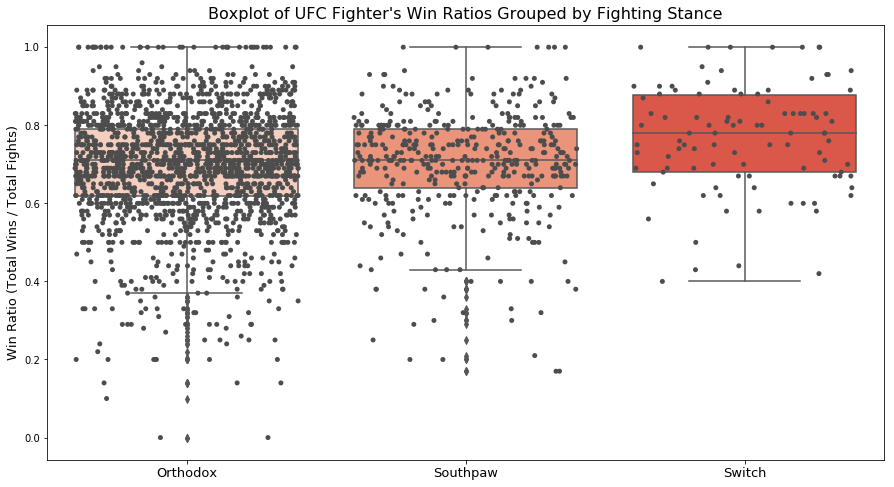

In [60]:
plt.figure(figsize=(15,8))
# sns.set_style("whitegrid")
sns.set_palette("Reds", 4)
sns.boxplot(x="stance",y="win_ratio",data=fighter_df,order=["Orthodox", "Southpaw", "Switch"])
sns.stripplot(x="stance", y="win_ratio", data=fighter_df, order=["Orthodox", "Southpaw", "Switch"], jitter=0.4, color="0.3")
plt.title("Boxplot of UFC Fighter's Win Ratios Grouped by Fighting Stance", fontsize=16)
plt.xlabel("")
plt.xticks([0,1,2],["Orthodox","Southpaw","Switch"],fontsize=13)
plt.ylabel("Win Ratio (Total Wins / Total Fights)", fontsize=13)

file_path = "/Users/ravimalde/dsc-files/student/Projects/ufc_fighter_stance/"
plt.savefig(file_path + "boxplot.png")

plt.show()

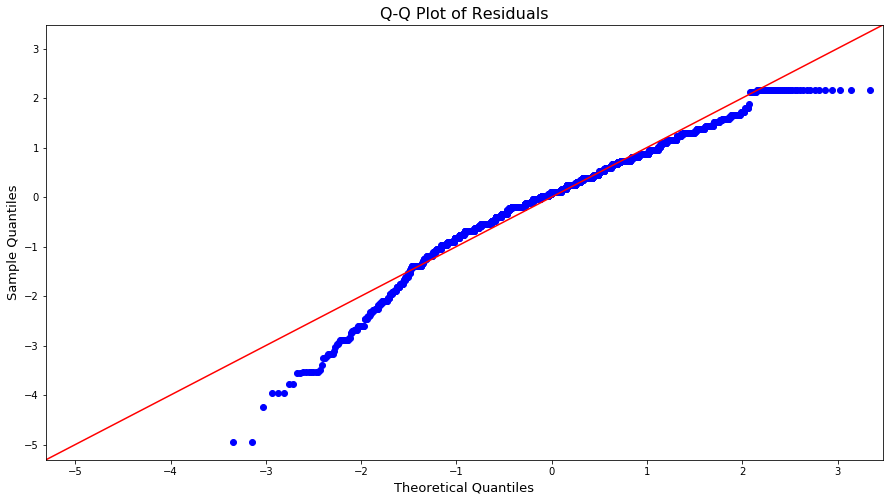

In [61]:
stance_model = ols("win_ratio ~ C(stance)", data=fighter_df).fit()
residuals = stance_model.resid

fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)

ax = plt.gca()
fig.set_size_inches(15, 8)
ax.set_xlabel("Theoretical Quantiles", fontsize=13)
ax.set_ylabel("Sample Quantiles", fontsize=13)
ax.set_title("Q-Q Plot of Residuals", fontsize=16)

file_path = "/Users/ravimalde/dsc-files/student/Projects/ufc_fighter_stance/"
plt.savefig(file_path + "residuals.png")

plt.show()

In [62]:
homoscedasticity_test = stats.levene(orthodox_df.win_ratio, southpaw_df.win_ratio, switch_df.win_ratio)
homoscedasticity_test

# P-value is > 0.05, therefore the datasets are homoscedastic

LeveneResult(statistic=0.7447379511847867, pvalue=0.4749679254981456)

In [63]:
lm = ols('win_ratio ~ C(stance) ',data=fighter_df).fit()
table = sm.stats.anova_lm(lm)
table

,df,sum_sq,mean_sq,F,PR(>F)
C(stance),2.0,0.450829,0.225415,11.367409,0.000012
Residual,2411.0,47.809905,0.019830,NaN,NaN


In [74]:
p_adjusted = multipletests(0.000012, alpha= 0.05, method='bonferroni')
p_adjusted

(array([ True]), array([1.2e-05]), 0.050000000000000044, 0.05)

In [75]:
mc = pairwise_tukeyhsd(fighter_df['win_ratio'], fighter_df['stance'])
# result = mc.tukeyhsd()
 
print(result)
print(mc.groupsunique)

ModuleNotFoundError: No module named 'statsmodels.stats.libqsturng'

In [65]:
orthodox_mean = orthodox_df["win_ratio"].mean()
southpaw_mean = southpaw_df["win_ratio"].mean()
switch_mean = switch_df["win_ratio"].mean()

orthodox_std = orthodox_df["win_ratio"].std()
southpaw_std = southpaw_df["win_ratio"].std()
switch_std = switch_df["win_ratio"].std()

In [66]:
cohens_d_southpaw_orthodox = (southpaw_mean - orthodox_mean)/(((southpaw_std**2 + orthodox_std**2)/2)**0.5)
cohens_d_southpaw_orthodox

0.029554675664638656

In [67]:
cohens_d_switch_orthodox = (switch_mean - orthodox_mean)/(((switch_std**2 + orthodox_std**2)/2)**0.5)
cohens_d_switch_orthodox

0.49952589926255675

In [68]:
cohens_d_southpaw_switch = (switch_mean - southpaw_mean)/(((switch_std**2 + southpaw_std**2)/2)**0.5)
cohens_d_southpaw_switch

0.4734877536967275

In [69]:
orthodox_southpaw_switch_dict = {'Orthodox':orthodox_mean, 'Southpaw':southpaw_mean, 'Switch':switch_mean}
print(orthodox_southpaw_switch_dict)

{'Orthodox': 0.6968769883351007, 'Southpaw': 0.7010232558139533, 'Switch': 0.7664285714285715}
